In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import export_text
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from IPython.display import display

!pip install xgboost
%matplotlib inline


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [123]:
df = pd.read_csv("finpay_data.csv", on_bad_lines='skip')

In [124]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

for col in df.columns:
    if 'date' in col.lower():
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [125]:
df.dtypes

wallet_id                        object
onboard_date             datetime64[ns]
user_class                       object
state                            object
gender                           object
region                           object
last_trans_date          datetime64[ns]
first_trans_date         datetime64[ns]
days_since_last_txn              object
days_to_first_txn                object
tenure_days                      object
age                               int64
total_txn_count                  object
total_tpv                        object
avg_tpv                          object
txn_count_30d                    object
tpv_30d                          object
avg_txn_value_30d                object
txn_count_90d                    object
tpv_90d                          object
avg_txn_value_90d                object
txn_trend                       float64
tpv_trend                       float64
avg_days_between_txn            float64
pos_share                       float64


In [126]:
df.isna().sum()

wallet_id                   0
onboard_date                0
user_class                  0
state                     357
gender                   4552
region                      0
last_trans_date          2182
first_trans_date         2182
days_since_last_txn      4498
days_to_first_txn        2182
tenure_days                 0
age                         0
total_txn_count             0
total_tpv                   0
avg_tpv                     0
txn_count_30d               0
tpv_30d                     0
avg_txn_value_30d           0
txn_count_90d               0
tpv_90d                     0
avg_txn_value_90d           0
txn_trend                   0
tpv_trend                   0
avg_days_between_txn        0
pos_share                   0
transfer_share              0
digital_service_share       0
loan_share                  0
deposit_share               0
total_commission            0
success_rate                0
churn_flag                  0
dtype: int64

In [127]:
cols_to_convert = [
    'days_to_first_txn',
    'days_since_last_txn',
    'tenure_days',
    'total_txn_count',
    'total_tpv',
    'avg_tpv',
    'txn_count_30d',
    'tpv_30d',
    'avg_txn_value_30d',
    'txn_count_90d',
    'tpv_90d',
    'avg_txn_value_90d',
    'total_commission'
]


for col in cols_to_convert:
    df[col] = (
        df[col]
        .astype(str)                        
        .str.replace(',', '', regex=False)  
        .str.replace('₦', '', regex=False)  
        .str.strip()                        
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')  

df[cols_to_convert] = df[cols_to_convert].fillna(0)

In [128]:
df.head()

,wallet_id,onboard_date,user_class,state,gender,region,last_trans_date,first_trans_date,days_since_last_txn,days_to_first_txn,...,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate,churn_flag
0,3c24443b-c103-442b-8d01-82b3e21d4866,2023-05-12,Terminal User,Ebonyi,Male,South East,2024-06-21 19:37:00,2023-05-12 12:01:00,510.0,406.0,...,0.0,0.11,0.17,0.13,0.69,0.0,0.0087,55080000,0.83,1
1,10a7707a-1880-4e9e-8883-50cb61485a63,2025-01-26,App User,Akwa Ibom,Male,South South,2025-02-06 17:45:00,2025-02-02 15:21:00,280.0,4.0,...,0.0,0.44,0.00,0.40,0.20,0.0,0.4000,2000,0.80,1
2,05345902-e5d8-40f2-b801-26169b5d8950,2023-08-02,Terminal User,Ondo,NaN,South West,2025-01-05 11:08:00,2023-08-02 16:43:00,312.0,522.0,...,0.0,174.00,0.00,0.25,0.00,0.0,0.7500,0,1.00,1
3,ebd6819c-3af1-4d71-b035-24071c65651a,2025-01-30,App User,NaN,Male,Other,NaT,NaT,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0
4,b4cee700-1a9f-4e19-a0d7-0a388154039c,2023-12-05,App User,Kwara,Male,South West,NaT,NaT,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0


In [129]:
df.drop(columns=['onboard_date', 'first_trans_date', 'last_trans_date', 'wallet_id'], inplace=True)

In [130]:
df.columns

Index(['user_class', 'state', 'gender', 'region', 'days_since_last_txn',
       'days_to_first_txn', 'tenure_days', 'age', 'total_txn_count',
       'total_tpv', 'avg_tpv', 'txn_count_30d', 'tpv_30d', 'avg_txn_value_30d',
       'txn_count_90d', 'tpv_90d', 'avg_txn_value_90d', 'txn_trend',
       'tpv_trend', 'avg_days_between_txn', 'pos_share', 'transfer_share',
       'digital_service_share', 'loan_share', 'deposit_share',
       'total_commission', 'success_rate', 'churn_flag'],
      dtype='object')

In [131]:
df.head()

,user_class,state,gender,region,days_since_last_txn,days_to_first_txn,tenure_days,age,total_txn_count,total_tpv,...,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate,churn_flag
0,Terminal User,Ebonyi,Male,South East,510.0,406.0,916,39,3672,8564647.98,...,0.0,0.11,0.17,0.13,0.69,0.0,0.0087,55080000,0.83,1
1,App User,Akwa Ibom,Male,South South,280.0,4.0,291,0,10,1200.00,...,0.0,0.44,0.00,0.40,0.20,0.0,0.4000,2000,0.80,1
2,Terminal User,Ondo,NaN,South West,312.0,522.0,834,36,4,2000.00,...,0.0,174.00,0.00,0.25,0.00,0.0,0.7500,0,1.00,1
3,App User,NaN,Male,Other,0.0,0.0,287,0,0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0
4,App User,Kwara,Male,South West,0.0,0.0,709,32,0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0


In [132]:
df.isna().sum()

user_class                  0
state                     357
gender                   4552
region                      0
days_since_last_txn         0
days_to_first_txn           0
tenure_days                 0
age                         0
total_txn_count             0
total_tpv                   0
avg_tpv                     0
txn_count_30d               0
tpv_30d                     0
avg_txn_value_30d           0
txn_count_90d               0
tpv_90d                     0
avg_txn_value_90d           0
txn_trend                   0
tpv_trend                   0
avg_days_between_txn        0
pos_share                   0
transfer_share              0
digital_service_share       0
loan_share                  0
deposit_share               0
total_commission            0
success_rate                0
churn_flag                  0
dtype: int64

In [133]:
df['state'] = df['state'].fillna('unknown')
df['gender'] = df['gender'].fillna('unknown')

In [134]:
df.head()

,user_class,state,gender,region,days_since_last_txn,days_to_first_txn,tenure_days,age,total_txn_count,total_tpv,...,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate,churn_flag
0,Terminal User,Ebonyi,Male,South East,510.0,406.0,916,39,3672,8564647.98,...,0.0,0.11,0.17,0.13,0.69,0.0,0.0087,55080000,0.83,1
1,App User,Akwa Ibom,Male,South South,280.0,4.0,291,0,10,1200.00,...,0.0,0.44,0.00,0.40,0.20,0.0,0.4000,2000,0.80,1
2,Terminal User,Ondo,unknown,South West,312.0,522.0,834,36,4,2000.00,...,0.0,174.00,0.00,0.25,0.00,0.0,0.7500,0,1.00,1
3,App User,unknown,Male,Other,0.0,0.0,287,0,0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0
4,App User,Kwara,Male,South West,0.0,0.0,709,32,0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0


In [135]:
df.isna().sum()

user_class               0
state                    0
gender                   0
region                   0
days_since_last_txn      0
days_to_first_txn        0
tenure_days              0
age                      0
total_txn_count          0
total_tpv                0
avg_tpv                  0
txn_count_30d            0
tpv_30d                  0
avg_txn_value_30d        0
txn_count_90d            0
tpv_90d                  0
avg_txn_value_90d        0
txn_trend                0
tpv_trend                0
avg_days_between_txn     0
pos_share                0
transfer_share           0
digital_service_share    0
loan_share               0
deposit_share            0
total_commission         0
success_rate             0
churn_flag               0
dtype: int64

In [136]:
df.describe().round()

,days_since_last_txn,days_to_first_txn,tenure_days,age,total_txn_count,total_tpv,avg_tpv,txn_count_30d,tpv_30d,avg_txn_value_30d,...,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate,churn_flag
count,10523.0,10523.0,10523.0,10523.0,10523.0,1.052300e+04,10523.0,10523.0,10523.0,10523.0,...,10523.0,10523.0,10523.0,10523.0,10523.0,10523.0,10523.0,1.052300e+04,10523.0,10523.0
mean,289.0,217.0,869.0,16.0,688.0,3.216126e+07,36611.0,4.0,67248.0,889.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.032714e+08,1.0,1.0
std,363.0,319.0,249.0,19.0,2025.0,1.950810e+09,2471492.0,29.0,916802.0,5915.0,...,0.0,13.0,0.0,0.0,0.0,0.0,0.0,6.779008e+09,0.0,0.0
min,0.0,0.0,29.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.837500e+05,0.0,0.0
25%,0.0,0.0,756.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
50%,35.0,20.0,1006.0,0.0,5.0,7.920000e+03,1000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.400000e+03,1.0,1.0
75%,595.0,353.0,1006.0,35.0,360.0,3.945652e+06,9746.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.532200e+05,1.0,1.0
max,1354.0,1289.0,1361.0,55.0,59274.0,2.000160e+11,253184810.0,1089.0,72873355.0,184579.0,...,1.0,532.0,1.0,1.0,1.0,0.0,1.0,6.240347e+11,1.0,1.0


In [137]:
# 70% train — 10% val — 20% test
n = len(df)
train_end = int(n * 0.7)
val_end   = int(n * 0.8)

df_train = df.iloc[:train_end]
df_val   = df.iloc[train_end:val_end]
df_test  = df.iloc[val_end:]

In [138]:
len(df_train), len(df_test), len(df_val)

(7366, 2105, 1052)

In [139]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [140]:
y_train = (df_train.churn_flag).astype('int').values
y_val = (df_val.churn_flag).astype('int').values
y_test = (df_test.churn_flag).astype('int').values

In [141]:
del df_train['churn_flag']
del df_val['churn_flag']
del df_test['churn_flag']

In [142]:
df_train.head()

,user_class,state,gender,region,days_since_last_txn,days_to_first_txn,tenure_days,age,total_txn_count,total_tpv,...,txn_trend,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate
0,Terminal User,Ebonyi,Male,South East,510.0,406.0,916,39,3672,8564647.98,...,0.0,0.0,0.11,0.17,0.13,0.69,0.0,0.0087,55080000,0.83
1,App User,Akwa Ibom,Male,South South,280.0,4.0,291,0,10,1200.00,...,0.0,0.0,0.44,0.00,0.40,0.20,0.0,0.4000,2000,0.80
2,Terminal User,Ondo,unknown,South West,312.0,522.0,834,36,4,2000.00,...,0.0,0.0,174.00,0.00,0.25,0.00,0.0,0.7500,0,1.00
3,App User,unknown,Male,Other,0.0,0.0,287,0,0,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00
4,App User,Kwara,Male,South West,0.0,0.0,709,32,0,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00


In [143]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [144]:
X_train

array([[3.90000e+01, 1.10000e-01, 2.33242e+03, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [0.00000e+00, 4.40000e-01, 1.20000e+02, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [3.60000e+01, 1.74000e+02, 5.00000e+02, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       ...,
       [0.00000e+00, 3.58000e+00, 9.70000e+03, ..., 4.60000e-01,
        1.00000e+00, 0.00000e+00],
       [3.30000e+01, 1.00000e-01, 2.67869e+04, ..., 3.70000e-01,
        0.00000e+00, 1.00000e+00],
       [0.00000e+00, 1.60000e-01, 4.87155e+03, ..., 3.00000e-01,
        0.00000e+00, 1.00000e+00]], shape=(7366, 74))

In [145]:
features = dv.get_feature_names_out()
pd.Series(features).value_counts()

age                         1
avg_days_between_txn        1
avg_tpv                     1
avg_txn_value_30d           1
avg_txn_value_90d           1
                           ..
txn_count_30d               1
txn_count_90d               1
txn_trend                   1
user_class=App User         1
user_class=Terminal User    1
Name: count, Length: 74, dtype: int64

In [146]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [147]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([2146, 5220]))

In [148]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [149]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

1.0

In [150]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.845
   2 -> 0.958
   3 -> 0.991
   4 -> 1.000
   5 -> 1.000
   6 -> 1.000
  10 -> 1.000
  15 -> 1.000
  20 -> 1.000
None -> 1.000


In [151]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- days_since_last_txn <= 60.00
|   |--- tenure_days <= 979.50
|   |   |--- class: 0
|   |--- tenure_days >  979.50
|   |   |--- txn_count_90d <= 0.50
|   |   |   |--- tenure_days <= 1007.00
|   |   |   |   |--- state=Ekiti <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- state=Ekiti >  0.50
|   |   |   |   |   |--- total_commission <= 50.00
|   |   |   |   |   |   |--- gender=unknown <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- gender=unknown >  0.50
|   |   |   |   |   |   |   |--- user_class=Terminal User <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- user_class=Terminal User >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- total_commission >  50.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- tenure_days >  1007.00
|   |   |   |   |--- class: 0
|   |   |--- txn_count_90d >  0.50
|   |   |   |--- class: 0
|--- days_since_last_txn >  60.00
|   |--- days_to

In [152]:
scoresd = []

for d in [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, None]:
    for s in [1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scoresd.append((d, s, auc))

In [153]:
scores_d = pd.DataFrame(scoresd, columns=['max_depth', 'min_samples_leaf', 'auc'])
scores_d.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
269,NaN,100,1.000000
268,NaN,90,1.000000
267,NaN,80,1.000000
266,NaN,70,1.000000
265,NaN,60,1.000000
...,...,...,...
4,1.0,15,0.844972
2,1.0,5,0.844972
3,1.0,10,0.844972
0,1.0,1,0.844972


In [154]:
df_scoresd_pivot = scores_d.pivot(index=['min_samples_leaf'], columns=['max_depth'], values=['auc'])
df_scoresd_pivot.round(3)

auc                                                   \
max_depth           NaN   1.0    2.0    3.0    4.0    5.0    6.0    7.0    
min_samples_leaf                                                           
1                 1.000  0.845  0.958  0.991  1.000  1.000  1.000  1.000   
2                 1.000  0.845  0.958  0.991  1.000  1.000  1.000  1.000   
5                 1.000  0.845  0.958  0.991  1.000  1.000  1.000  1.000   
10                1.000  0.845  0.958  0.991  1.000  1.000  1.000  1.000   
15                1.000  0.845  0.959  0.991  1.000  1.000  1.000  1.000   
20                1.000  0.845  0.959  0.991  1.000  1.000  1.000  1.000   
30                1.000  0.845  0.959  0.990  1.000  1.000  1.000  1.000   
40                1.000  0.845  0.959  0.990  1.000  1.000  1.000  1.000   
50                1.000  0.845  0.959  0.990  1.000  1.000  1.000  1.000   
60                1.000  0.845  0.959  0.991  1.000  1.000  1.000  1.000   
70                1.000  0.845  0.959  0.991  1.000  1.000  1.000  1.000   
80                1.000  0.845  0.959  0.991  1.000  1.000  1.000  1.000   
90                1.000  0.845  0.959  0.991  1.000  1.000  1.000  1.000   
100               1.000  0.845  0.959  0.991  1.000  1.000  1.000  1.000   
200               0.998  0.845  0.959  0.991  0.997  0.998  0.998  0.998   
500               0.990  0.845  0.959  0.984  0.990  0.990  0.990  0.990   

                                                                          \
max_depth          10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0   
min_samples_leaf                                                           
1                 1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
2                 1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
5                 1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
10                1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
15                1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
20                1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
30                1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
40                1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
50                1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
60                1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
70                1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
80                1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
90                1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
100               1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   
200               0.998  0.998  0.998  0.998  0.998  0.998  0.998  0.998   
500               0.990  0.990  0.990  0.990  0.990  0.990  0.990  0.990   

                         
max_depth          50.0  
min_samples_leaf         
1                 1.000  
2                 1.000  
5                 1.000  
10                1.000  
15                1.000  
20                1.000  
30                1.000  
40                1.000  
50                1.000  
60                1.000  
70                1.000  
80                1.000  
90                1.000  
100               1.000  
200               0.998  
500               0.990

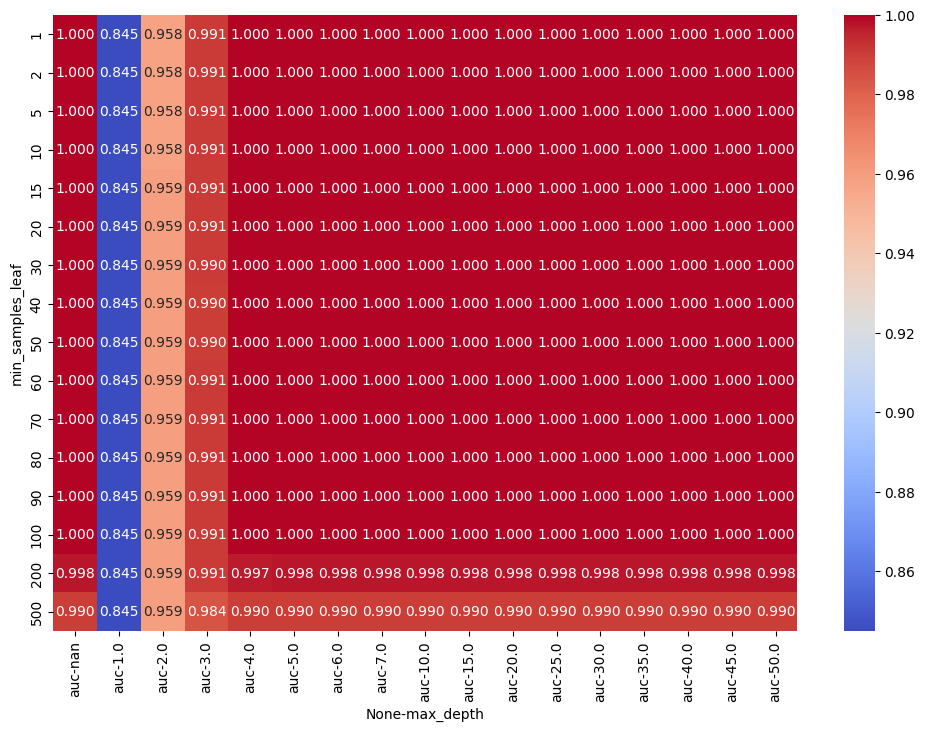

In [155]:
plt.figure(figsize=(12, 8))  # width=12, height=8
sns.heatmap(df_scoresd_pivot, annot=True, fmt='.3f', cmap='coolwarm')  # optional: add a color map
plt.show()

In [156]:
best_score = df_scoresd_pivot.max().max()
best_leaf, best_depth = np.where(df_scoresd_pivot == best_score)

In [157]:
best_min_leaf = df_scoresd_pivot.index[best_leaf[0]]
best_max_depth = df_scoresd_pivot.columns[best_depth[0]]

In [158]:
print(f"✅ Best score: {best_score}")
print(f"🌿 Best min_samples_leaf: {best_min_leaf}")
print(f"🌳 Best max_depth: {best_max_depth}")

✅ Best score: 1.0
🌿 Best min_samples_leaf: 1
🌳 Best max_depth: ('auc', nan)


In [159]:
#final tuning max_depth = 10 and min_samples_leaf = 30
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=30)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,30
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [160]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

1.0

In [161]:
scorerf = []
for n in range(10, 301, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scorerf.append((n, auc))

In [162]:
scoress_rf = pd.DataFrame(scorerf, columns=['n_estimator', 'auc'])
scoress_rf.sort_values(by='auc', ascending=False)

,n_estimator,auc
10,110,0.999946
11,120,0.999944
15,160,0.999944
8,90,0.999942
9,100,0.999942
6,70,0.999942
14,150,0.999942
17,180,0.999942
13,140,0.999942
12,130,0.999940


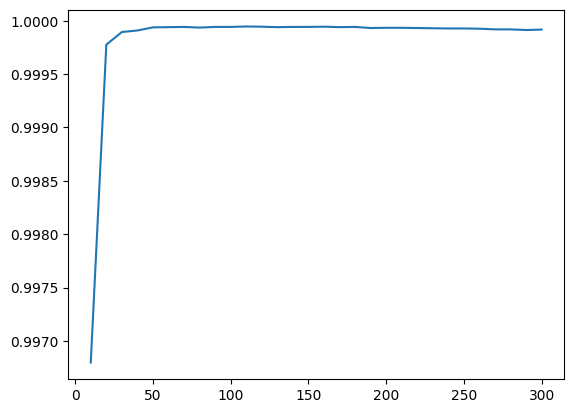

In [163]:
plt.plot(scoress_rf.n_estimator, scoress_rf.auc)

In [164]:
scorerfd = []

for d in [10, 15, 20, 25, 30, 35, 40]:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scorerfd.append((n, d, auc))

In [165]:
scored_rdf = pd.DataFrame(scorerfd, columns=['n_estimator', 'max_depth', 'auc'])

In [166]:
scored_rdf.sort_values(by='auc')

,n_estimator,max_depth,auc
120,10,30,0.996799
150,10,35,0.996799
180,10,40,0.996799
60,10,20,0.998165
90,10,25,0.998306
...,...,...,...
34,50,15,0.999975
42,130,15,0.999975
44,150,15,0.999975
70,110,20,0.999975


In [167]:
max_depth = 10
min_samples_leaf = 30
n_estimator = 260

In [168]:
rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,260
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,30
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [169]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

auc

0.9994804136738494

In [170]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [171]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [172]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9991520351157223

In [173]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}

learning_rates = [0.3, 0.2, 0.1, 0.05, 0.01]

for lr in learning_rates:
    xgb_params['learning_rate'] = lr
    model = xgb.train(
        xgb_params, dtrain, num_boost_round=1000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50
    )
    print(f"LR: {lr}, Best AUC: {model.best_score}, Best iteration: {model.best_iteration}")

[0]	validation-auc:0.99804
[1]	validation-auc:0.99843
[2]	validation-auc:0.99884
[3]	validation-auc:0.99874
[4]	validation-auc:0.99874
[5]	validation-auc:0.99872
[6]	validation-auc:0.99912
[7]	validation-auc:0.99886
[8]	validation-auc:0.99890
[9]	validation-auc:0.99913
[10]	validation-auc:0.99909
[11]	validation-auc:0.99915
[12]	validation-auc:0.99883
[13]	validation-auc:0.99916
[14]	validation-auc:0.99919
[15]	validation-auc:0.99919
[16]	validation-auc:0.99921
[17]	validation-auc:0.99938
[18]	validation-auc:0.99930
[19]	validation-auc:0.99913
[20]	validation-auc:0.99941
[21]	validation-auc:0.99935
[22]	validation-auc:0.99942
[23]	validation-auc:0.99939
[24]	validation-auc:0.99922
[25]	validation-auc:0.99922
[26]	validation-auc:0.99918
[27]	validation-auc:0.99914
[28]	validation-auc:0.99908
[29]	validation-auc:0.99924
[30]	validation-auc:0.99915
[31]	validation-auc:0.99916
[32]	validation-auc:0.99922
[33]	validation-auc:0.99922
[34]	validation-auc:0.99923
[35]	validation-auc:0.99926
[3

In [174]:
#LR: 0.01, Best AUC: 0.9996429443625549, Best iteration: 107
#LR: 0.05, Best AUC: 0.9998364630668191, Best iteration: 89
#LR: 0.1, Best AUC: 0.9998288313432706, Best iteration: 41
#LR: 0.2, Best AUC: 0.9998321020819342, Best iteration: 20
#LR: 0.3, Best AUC: 0.9998380984361508, Best iteration: 13

dic = {"0.01": 0.9996429443625549, "0.05": 0.9998364630668191, "0.1": 0.9998288313432706, "0.2": 0.9998321020819342, "0.3": 0.9998380984361508}
best_lr = max(dic, key=dic.get)
print("Best learning rate:", best_lr)

Best learning rate: 0.3


In [175]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}

max_depth_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]

for md in max_depth_values:
    xgb_params['max_depth'] = md
    model = xgb.train(
        xgb_params, dtrain, num_boost_round=1000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50
    )
    print(f"MD: {md}, Best AUC: {model.best_score}, Best iteration: {model.best_iteration}")

[0]	validation-auc:0.95731
[1]	validation-auc:0.98619
[2]	validation-auc:0.98707
[3]	validation-auc:0.98912
[4]	validation-auc:0.99694
[5]	validation-auc:0.99815
[6]	validation-auc:0.99817
[7]	validation-auc:0.99812
[8]	validation-auc:0.99807
[9]	validation-auc:0.99809
[10]	validation-auc:0.99845
[11]	validation-auc:0.99842
[12]	validation-auc:0.99842
[13]	validation-auc:0.99839
[14]	validation-auc:0.99839
[15]	validation-auc:0.99841
[16]	validation-auc:0.99834
[17]	validation-auc:0.99838
[18]	validation-auc:0.99836
[19]	validation-auc:0.99833
[20]	validation-auc:0.99845
[21]	validation-auc:0.99842
[22]	validation-auc:0.99931
[23]	validation-auc:0.99937
[24]	validation-auc:0.99933
[25]	validation-auc:0.99933
[26]	validation-auc:0.99936
[27]	validation-auc:0.99933
[28]	validation-auc:0.99935
[29]	validation-auc:0.99935
[30]	validation-auc:0.99941
[31]	validation-auc:0.99940
[32]	validation-auc:0.99940
[33]	validation-auc:0.99940
[34]	validation-auc:0.99940
[35]	validation-auc:0.99941
[3

In [176]:
#2, Best AUC: 0.9998778924232249, Best iteration: 88
#MD: 3, Best AUC: 0.9997263481984772, Best iteration: 39
#MD: 4, Best AUC: 0.9998648094685704, Best iteration: 22
#MD: 5, Best AUC: 0.9997955788335238, Best iteration: 9
#MD: 6, Best AUC: 0.9998380984361508, Best iteration: 13
#MD: 7, Best AUC: 0.9998211996197222, Best iteration: 13
#MD: 8, Best AUC: 0.999820109373501, Best iteration: 14
#MD: 9, Best AUC: 0.999820109373501, Best iteration: 14
#MD: 10, Best AUC: 0.999820109373501, Best iteration: 14
#MD: 12, Best AUC: 0.999820109373501, Best iteration: 14
#MD: 15, Best AUC: 0.999820109373501, Best iteration: 14
#MD: 20, Best AUC: 0.999820109373501, Best iteration: 14

dicmd = {"2": 0.9998778924232249, "3": 0.9997263481984772,  
"4": 0.9998648094685704, "5": 0.9997955788335238, "6": 0.9998380984361508, 
"7":  0.9998211996197222, "8": 0.999820109373501, "9": 0.999820109373501, "10": 0.999820109373501,
"12":  0.999820109373501, "15": 0.999820109373501, "20": 0.999820109373501 }

best_md = max(dicmd, key=dicmd.get)
print("Best max depth:", best_md)
print("Highest value:", dicmd[best_md])

Best max depth: 2
Highest value: 0.9998778924232249


In [177]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}

min_child_weight_values = [1, 2, 3, 4, 5, 7, 10, 15, 20]

for mcw in min_child_weight_values:
    xgb_params['learning_rate'] = mcw
    model = xgb.train(
        xgb_params, dtrain, num_boost_round=1000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50
    )
    print(f"MCW: {mcw}, Best AUC: {model.best_score}, Best iteration: {model.best_iteration}")

[0]	validation-auc:0.99804
[1]	validation-auc:0.99889
[2]	validation-auc:0.99937
[3]	validation-auc:0.99923
[4]	validation-auc:0.99929
[5]	validation-auc:0.99905
[6]	validation-auc:0.99913
[7]	validation-auc:0.99922
[8]	validation-auc:0.99921
[9]	validation-auc:0.99923
[10]	validation-auc:0.99918
[11]	validation-auc:0.99933
[12]	validation-auc:0.99935
[13]	validation-auc:0.99935
[14]	validation-auc:0.99935
[15]	validation-auc:0.99943
[16]	validation-auc:0.99943
[17]	validation-auc:0.99943
[18]	validation-auc:0.99940
[19]	validation-auc:0.99938
[20]	validation-auc:0.99940
[21]	validation-auc:0.99938
[22]	validation-auc:0.99942
[23]	validation-auc:0.99942
[24]	validation-auc:0.99934
[25]	validation-auc:0.99941
[26]	validation-auc:0.99943
[27]	validation-auc:0.99939
[28]	validation-auc:0.99932
[29]	validation-auc:0.99932
[30]	validation-auc:0.99940
[31]	validation-auc:0.99932
[32]	validation-auc:0.99940
[33]	validation-auc:0.99939
[34]	validation-auc:0.99933
[35]	validation-auc:0.99939
[3

In [178]:
dicmcw = {
 1: 0.9998658997147916,
 2: 0.9997606909544452,
 3: 0.9929935326594158,
 4: 0.9929935326594158,
 5: 0.9929935326594158,
 7: 0.9929935326594158,
 10: 0.9920777258336022,
 15: 0.9920777258336022,
 20: 0.9920875380495932
}



best_mcw = max(dicmcw, key=dicmcw.get)
print("Best min_child_weight:", best_mcw)
print("Highest value:", dicmcw[best_mcw])


Best min_child_weight: 1
Highest value: 0.9998658997147916


In [179]:
#min_child_weight = 1
#max_depth = 2
#eta = 0.3

In [180]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 2,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)


y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9995199022346368

In [181]:
all_model = {"dt": 0.9995061184617934,
"rf": 0.9991463372087952, "xgb": 0.9998380984361508}

best_model = max(all_model, key=all_model.get)
print("Best model:", best_model)
print("Best model auc score:", all_model[best_model])

Best model: xgb
Best model auc score: 0.9998380984361508


In [182]:
#XGB is the best

In [ ]:
df_train.head()

In [ ]:
y_full_train = (df_train.churn_flag == 1).astype(int).values

In [ ]:
y_full_train

In [ ]:
del df_full_train['churn_flag']

In [ ]:
df_full_train.head()

In [184]:
dict_full_train = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)

dict_test = df_test.to_dict(orient='records')
X_test = dv.transform(dict_test)

In [185]:
dfulltrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.get_feature_names_out().tolist())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [186]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 2,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dfulltrain, num_boost_round=100)


y_pred = model.predict(dtest)
roc_auc_score(y_val, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [1052, 2105]

In [ ]:
#second best on training
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=30)
dt.fit(X_full_train, y_full_train)
y_pred = dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

In [ ]:
rf = RandomForestClassifier(n_estimators=260, max_depth=10, min_samples_leaf=30, random_state=1)
rf.fit(X_full_train, y_full_train)
y_pred = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_val, y_pred)

auc